In [1]:
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-xia3ba8o
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-xia3ba8o
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d57b7517150f1eb28a09b868f17aec5b6d2cc4fb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-0y_b5beh/elegantrl_4e5233d20eff4dc382b0b627fb894844
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-0y_b5beh/elegantrl_4e5233d20eff4dc382b0b627fb894844
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit a531d493b710a872a4943532872846e00ad96abf
  Preparing met

In [164]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

## Import packages

In [1]:

from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
sys.path.append("../FinRL-Library")

/home/jenchang/.local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


## Load Data

In [2]:
# Prepare data
dividends = pd.read_csv('/home/jenchang/drl_finance/data/asset_Dividends.csv')
monetum = pd.read_csv('/home/jenchang/drl_finance/data/asset_monetum.csv')
# price = pd.read_csv('/home/jenchang/drl_finance/data/asset_price.csv')
sma = pd.read_csv('/home/jenchang/drl_finance/data/asset_sma.csv')
rate = pd.read_csv('/home/jenchang/drl_finance/data/bond_rate.csv')
fred = pd.read_csv('/home/jenchang/drl_finance/data/fred_data.csv')
fund = pd.read_csv('/home/jenchang/drl_finance/data/fundamentals.csv')
tips = pd.read_csv('/home/jenchang/drl_finance/data/TIPS_signal.csv')

# data =pd.DataFrame({'Date': dividends['Date']})
# data = data.merge(dividends, on='Date', how = 'left')
# data = data.merge(monetum, on='Date', how = 'left')
# # data = data.merge(price, on='Date', how = 'left')
# data = data.merge(sma, on='Date', how = 'left')
# data = data.merge(rate, on='Date', how = 'left')
# data = data.merge(fred, on='Date', how = 'left')
# data = data.merge(fund, on='Date', how = 'left')
# data = data.merge(tips, on='Date', how = 'left')



In [3]:
dividends_pivots = pd.DataFrame()
stock_list = ["SPY","AGG","QQQ","VNQ","IWM","VIG","IEF"]
for stock in stock_list:
    temp_df = dividends[['Date', f'Dividends_{stock}', f'Dividends_growth_{stock}']]
    temp_df = temp_df.rename(columns = {f'Dividends_{stock}': 'Dividends', f'Dividends_growth_{stock}':'Dividends_growth'})
    temp_df['tic'] = stock

    dividends_pivots = pd.concat([dividends_pivots, temp_df])


In [4]:
monetum_pivots = pd.DataFrame()
stock_list = ["SPY","AGG","QQQ","VNQ","IWM","VIG","IEF"]
for stock in stock_list:
    temp_df = monetum[['Date', f'{stock}_20', f'{stock}_60', f'{stock}_120', f'{stock}_180', f'{stock}_240', f'{stock}_sum', f'{stock}_avg']]
    temp_df = temp_df.rename(columns = {f'{stock}_20': 'monetum_20', f'{stock}_40': 'monetum_40', f'{stock}_60': 'monetum_60', f'{stock}_120': 'monetum_120', f'{stock}_180': 'monetum_180',f'{stock}_240': 'monetum_240', f'{stock}_sum': 'monetum_sum', f'{stock}_avg': 'monetum_avg'})
    temp_df['tic'] = stock

    monetum_pivots = pd.concat([monetum_pivots, temp_df])   


In [5]:
sma_pivots = pd.DataFrame()
stock_list = ["SPY","AGG","QQQ","VNQ","IWM","VIG","IEF"]
for stock in stock_list:
    temp_df = sma[['Date', f'{stock}_close_20_sma', f'{stock}_close_50_sma', f'{stock}_close_100_sma']]
    temp_df = temp_df.rename(columns = {f'{stock}_close_20_sma': 'sma_20', f'{stock}_close_50_sma': 'sma_50', f'{stock}_close_100_sma': 'sma_100'})
    temp_df['tic'] = stock

    sma_pivots = pd.concat([sma_pivots, temp_df])   

In [6]:
import datetime
import yfinance as yf
from datetime import date
from datetime import timedelta
stock_list = ["SPY","AGG","QQQ","VNQ","IWM","VIG","IEF"]
start_date = '2007-03-01'
end_date = '2024-03-31'
# end_date = '2024-03-31'
start_date = pd.Timestamp(start_date)
end_date = pd.Timestamp(end_date)
delta = timedelta(days=1)
data_df = pd.DataFrame()
for tic in stock_list:

    # while (
    #     start_date <= end_date
    # ):  # downloading daily to workaround yfinance only allowing  max 7 calendar (not trading) days of 1 min data per single download
    temp_df = yf.download(
        tic,
        start=start_date,
        end=end_date,
        interval='1d',
        proxy=None,
    )
    temp_df["tic"] = tic
    data_df = pd.concat([data_df, temp_df])
        # start_date += delta

data_df = data_df.reset_index().drop(columns=["Adj Close"])
# convert the column names to match processor_alpaca.py as far as poss
data_df.columns = [
    "timestamp",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "tic",
]
data_df = data_df.rename(columns={'timestamp': 'Date'})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
dividends_pivots['Date'] = pd.to_datetime(dividends_pivots['Date'])
data_df = data_df.merge(dividends_pivots, on=['Date','tic'], how = 'left')

monetum_pivots['Date'] = pd.to_datetime(monetum_pivots['Date'])
data_df = data_df.merge(monetum_pivots, on=['Date','tic'], how = 'left')

sma_pivots['Date'] = pd.to_datetime(sma_pivots['Date'])
data_df = data_df.merge(sma_pivots, on=['Date','tic'], how = 'left')

rate.fillna(method = 'ffill', inplace = True)
rate['Date'] = pd.to_datetime(rate['Date'])
data_df = data_df.merge(rate, on=['Date'], how = 'left')

fred['Date'] = pd.to_datetime(fred['Date'])
data_df = data_df.merge(fred, on=['Date'], how = 'left')

fund['Date'] = pd.to_datetime(fund['Date'])
data_df = data_df.merge(fund, on=['Date'], how = 'left')

tips['Date'] = pd.to_datetime(tips['Date'])
data_df = data_df.merge(tips, on=['Date'], how = 'left')




/tmp/ipykernel_734/2140797064.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rate.fillna(method = 'ffill', inplace = True)


#Preprocess data
##Add covariance matrix as states

In [8]:
# # add covariance matrix as states
data_df=data_df.sort_values(['Date','tic'],ignore_index=True)
data_df.index = data_df.Date.factorize()[0]

cov_list = []
return_list = []

# # look back is one year
lookback= 2
for i in range(lookback,len(data_df.index.unique())):
  data_lookback = data_df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'Date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'Date':data_df.Date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
data_df = data_df.merge(df_cov, on='Date')
data_df = data_df.sort_values(['Date','tic']).reset_index(drop=True)

#Training data split : 2007-03-01 to 2020-03-31


In [9]:
data_df = data_df.rename(columns ={'Date': 'date'})
train = data_split(data_df, '2007-03-01','2020-03-31')

#Build environment for portfolio allocation


In [233]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,)) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-5
        # print(self.terminal)
        # print(actions)

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            #print("Model actions: ",actions)
            # actions are the portfolio weight
            # normalize to sum of 1
            #if (np.array(actions) - np.array(actions).min()).sum() != 0:
            #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
            #else:
            #  norm_actions = actions
            weights = self.softmax_normalization(actions) 
            #print("Normalized actions: ", weights)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            # self.day += 1 #原code 每天交易
            self.day +=5 #每5天交易一次
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)

            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            dividends_growth = sum(self.data.Dividends_growth.values*weights)
            monetum = sum(self.data.monetum_avg*weights)
            asset_volatility = self.variance(last_day_memory, weights)
            
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            # self.reward = new_portfolio_value #改
            r = np.array([portfolio_return, dividends_growth, monetum])
            reward_weights = self.gradient_ascent(R=r)
            # self.reward = sum(r * reward_weights)
            self.reward = sum(r * reward_weights) - 0.01* asset_volatility
            # self.reward = self.reward*self.reward_scaling

        return self.state, self.reward, self.terminal, {}
    
    def compute_gradient(self,R):
        gradient = -R
        return gradient
    
    def gradient_ascent(self, learning_rate=0.01, num_iterations=10, initial_weights=np.array([0.34,0.33,0.33]), R=np.array([])):
        weights = initial_weights
        if  R.size != 0:  
            for i in range(num_iterations):
                gradient = self.compute_gradient(R)
                weights = weights + learning_rate * gradient  # 更新權重
                # print(f"Iteration {i+1}: Weights = {weights}") 
        return weights

    def variance(self, last_day_memory, weights):
        vic_list = self.data['tic'].unique()
        returns_asset = pd.DataFrame()
        for i,v in enumerate(vic_list):
            returns_asset[f'returns_asset_{i}'] = (self.data[self.data['tic'] == v].close.values / last_day_memory[last_day_memory['tic']==v].close.values)-1
        
        filtered_data = np.array(list(returns_asset.values))
        cov_matrix = np.cov(filtered_data)

        portfolio_volatility_advanced = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        return portfolio_volatility_advanced


    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    def save_profolio_return_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value
    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_value = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'asset_value':asset_value})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [234]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

indicator_list =['Dividends',
       'Dividends_growth', 'monetum_20', 'monetum_60', 'monetum_120',
       'monetum_180', 'monetum_240', 'monetum_sum', 'monetum_avg', 'sma_20',
       'sma_50', 'sma_100', 'Close_US1M', 'Close_US3M', 'Close_DGS5',
       'Close_DGS10', 'DFF', 'CPIAUCSL', 'CSUSHPINSA', 'CPIAUCSL_PC1',
       'CPILFESL_PC1', 'GDP', 'GDPC1', '^VIX', '^GSPC', '^DJI', '^IXIC',
       '^RUT', '^W5000FLT', 'GC=F', 'CL=F', 'Bull-Bear Spread',
       'TIPS_adj_close', 'TIPS_240', 'TIPS_momentum']
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 7, State Space: 7
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


/home/jenchang/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


#Implement DRL Algorithms

In [235]:
# initialize
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
model_ddpg = agent.get_model("ddpg",model_kwargs = DDPG_PARAMS)

trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
begin_total_asset:1000000
end_total_asset:1670763.0111233825
Sharpe:  0.7532455765728573
begin_total_asset:1000000
end_total_asset:1617190.7857342176
Sharpe:  0.7037929292712396
begin_total_asset:1000000
end_total_asset:1617190.7857342176
Sharpe:  0.7037929292712396
begin_total_asset:1000000
end_total_asset:1617190.7857342176
Sharpe:  0.7037929292712396
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 56         |
|    time_elapsed    | 47         |
|    total_timesteps | 2636       |
| train/             |            |
|    actor_loss      | 917        |
|    critic_loss     | 3.51e+04   |
|    learning_rate   | 0.001      |
|    n_updates       | 2535       |
|    reward          | -43.211903 |
-----------------------------------
begin_total_asset:1000000
end_total_asset:1617190.7857342176
Sharpe:  0.7037929292712396
beg

In [290]:
trained_ddpg.save('/home/jenchang/drl_finance/trained_models/trained_ddpg_0506_new_reward_no_violty.zip')

##Trading

In [236]:
trade = data_split(data_df,'2020-04-01', '2024-03-31')
trade['^W5000FLT'] = trade['^W5000FLT'].str.replace(',', '')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [238]:

# df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
#                         environment = e_trade_gym)
environment = e_trade_gym
model=trained_ddpg 
deterministic=True
test_env, test_obs = environment.get_sb_env()
account_memory = None  # This help avoid unnecessary list creation
actions_memory = None  # optimize memory consumption
# state_memory=[] #add memory pool to store states

test_env.reset()
max_steps = len(environment.df.index.unique()) -5

for i in range(len(environment.df.index.unique())):
    action, _states = model.predict(test_obs, deterministic=deterministic)
    asset_memory = test_env.env_method(method_name="save_asset_memory")
    actions_memory = test_env.env_method(method_name="save_action_memory")
    account_memory = test_env.env_method(method_name="save_profolio_return_memory")
    test_obs, rewards, dones, info = test_env.step(action)

    # if (
    #     i == max_steps - 5
    # ):  # more descriptive condition for early termination to clarify the logic
    #     account_memory = test_env.env_method(method_name="save_asset_memory")
    #     actions_memory = test_env.env_method(method_name="save_action_memory")
    # add current state to state memory
    # state_memory=test_env.env_method(method_name="save_state_memory")
    if dones[0]:
        print("hit end!")
        break
    df_profolio_value, df_daily_return, df_actions = asset_memory[0],account_memory[0], actions_memory[0]

/home/jenchang/.local/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:1432437.3597497842
Sharpe:  1.5366031457434524
hit end!


## Caculate the result

In [301]:
class Evaluation:
    def __init__(self,df_profolio_value, df_daily_return, df_actions, period_year, trade_period=5):
        self.df_profolio_value = df_profolio_value
        self.df_daily_return = df_daily_return
        self.df_actions = df_actions
        self.trade_period = trade_period
        self.period_year = period_year
        
        trade_day_a_year = 252 # 每年的交易日數
        self.trade_times = trade_day_a_year / self.trade_period

    def get_annual_return(self):
        initial_investment = self.df_profolio_value['asset_value'].iloc[0]  # 初始投資額
        final_value = self.df_profolio_value['asset_value'].iloc[-1]     # 結束時的投資價值

        # 投資期間（以年為單位）
        years = self.period_year
        # 計算總回報率
        total_return = (final_value - initial_investment) / initial_investment
        # 計算年化回報率
        annual_return = (1 + total_return) ** (1 / years) - 1
        print(f"The annualized return is: {annual_return :.2%}")

        return annual_return

    def get_max_drawdown(self):
        # 计算累积最大值
        self.df_profolio_value['cumulative_max'] = self.df_profolio_value['asset_value'].cummax()

        # 计算从峰值到当前值的回撤
        self.df_profolio_value['drawdown'] = (self.df_profolio_value['asset_value'] - self.df_profolio_value['cumulative_max']) / self.df_profolio_value['cumulative_max']

        # 计算最大回撤
        max_drawdown = self.df_profolio_value['drawdown'].min()
        print(f"Max Drawdown: {max_drawdown:.2%}")

        return max_drawdown

    def get_cumulative_returns(self):
        cumulative_return = (1 + self.df_daily_return['daily_return']).prod() - 1
        print(f"Cumulative Return: {cumulative_return:.2%}")

        return cumulative_return
    
    def get_annual_volatility(self):
        annual_volatility = self.df_daily_return['daily_return'].std() * np.sqrt(self.trade_times)
        print(f"Annual Volatility: {annual_volatility:.2%}")

        return annual_volatility
    
    def get_sharpe_ratio(self, risk_free_rate_annual=0.014):
        risk_free_rate_per_period = (1 + risk_free_rate_annual) ** (1/self.trade_times) - 1
        #計算年化報酬
        annual_return = self.get_annual_return()
        annual_volatility = self.get_annual_volatility()
        sharpe_ratio = (annual_return - risk_free_rate_per_period) / annual_volatility
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

        return sharpe_ratio


#Backtest 

In [303]:
evaluate = Evaluation(df_profolio_value, df_daily_return, df_actions,4)
sharpe_ratio = evaluate.get_sharpe_ratio()
max_drawdown = evaluate.get_max_drawdown()
cumulative_returns = evaluate.get_cumulative_returns()

The annualized return is: 9.16%
Annual Volatility: 14.72%
Sharpe Ratio: 0.62
Max Drawdown: -25.39%
Cumulative Return: 41.98%


#60:40 投資策略 、 等比投資策略

In [444]:
 #資產重配置日期
trade_day = pd.DataFrame(df_profolio_value['date'])
initial_investment = 1000000
stocks = ["SPY","QQQ","VNQ","IWM","VIG"]
bonds = ["AGG","IEF"] 

start_date = '2020-04-01'
end_date = '2024-03-31'

#download data
data = yf.download(stocks + bonds, start="2020-04-01", end="2024-03-31")['Adj Close']
data = data.reset_index()
data = data.merge(trade_day, how='inner', right_on='date', left_on='Date').drop('Date', axis=1)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


[                       0%%                      ]

[*********************100%%**********************]  7 of 7 completed


In [445]:
# 60:40

stock_ratio = 0.6
bond_ratio = 0.4
stock_weight = stock_ratio / len(stocks)  # 每只股票的权重
bond_weight = bond_ratio/ len(bonds)    # 每只债券的权重
weights = np.array([stock_weight]* len(stocks) + [bond_weight]* len(bonds))
initial_investment = 1000000

# 计算每个资产的初始投资
stock_investment = initial_investment * stock_ratio / len(stocks)
bond_investment = initial_investment * bond_ratio / len(bonds)


# Caculate daily action & value
df_values_6040 = pd.DataFrame(trade_day)

# 计算初始持股数
df_values_6040['SPY'] = stock_investment / data['SPY'].iloc[0] 
df_values_6040['QQQ'] = stock_investment / data['QQQ'].iloc[0] 
df_values_6040['VNQ'] = stock_investment / data['VNQ'].iloc[0] 
df_values_6040['IWM'] = stock_investment / data['IWM'].iloc[0] 
df_values_6040['VIG'] = stock_investment / data['VIG'].iloc[0] 
df_values_6040['AGG'] = bond_investment  / data['AGG'].iloc[0] 
df_values_6040['IEF'] = bond_investment  / data['IEF'].iloc[0] 

#每5天重新平衡投資組合(持股數)
for i in range(len(data)):
    # 计算当前市值
    current_market_value = sum(data.loc[data.index[i], stock] * df_values_6040.loc[df_values_6040.index[i], stock] for stock in stocks) + \
                           sum(data.loc[data.index[i], bond] * df_values_6040.loc[df_values_6040.index[i], bond] for bond in bonds)
    
    # 重新计算投资
    stock_investment = current_market_value * stock_ratio / len(stocks)
    bond_investment = current_market_value * bond_ratio / len(bonds)
    
    # 更新持股数
    for stock in stocks:
        df_values_6040.loc[df_values_6040.index[i], stock] = stock_investment / data.loc[data.index[i], stock]
    for bond in bonds:
        df_values_6040.loc[df_values_6040.index[i], bond] = bond_investment / data.loc[data.index[i], bond]


#計算daily returns

df_returns_6040 = pd.DataFrame(trade_day)
df_returns_6040['SPY'] = 0
df_returns_6040['QQQ'] = 0
df_returns_6040['VNQ'] = 0
df_returns_6040['IWM'] = 0
df_returns_6040['VIG'] = 0
df_returns_6040['AGG'] = 0
df_returns_6040['IEF'] = 0

day = 1
the_past_day = 0
for i in range(len(data)):
    if i <len(data):
        i+=1
        df_returns_6040.loc[i] = ((data.loc[data.index[day]] / data.loc[data.index[the_past_day]])-1) * weights
        day += 1
        the_past_day += 1

# stock_returns = daily_returns[stocks].mean(axis=1) * stock_ratio
# bond_returns = daily_returns[bonds].mean(axis=1) * bond_ratio
# portfolio_daily_returns_6040 = stock_returns + bond_returns
# portfolio_daily_returns_6040 = portfolio_daily_returns_6040.fillna(0)
# portfolio_daily_returns_6040= portfolio_daily_returns_6040.reset_index()
# portfolio_daily_returns_6040 = portfolio_daily_returns_6040.rename(columns = {'Date': 'date', 0: 'daily_return'})

# #計算綜合評量結果
# set6040_strat = convert_daily_return_to_pyfolio_ts(portfolio_daily_returns_6040)
# perf_func = timeseries.perf_stats 
# perf_stats_all_6040 = perf_func( returns=set6040_strat, 
#                               factor_returns=set6040_strat, 
#                                 positions=None, transactions=None, turnover_denom="AGB")

/tmp/ipykernel_734/1340224933.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01359172070895192' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_returns_6040.loc[i] = ((data.loc[data.index[day]] / data.loc[data.index[the_past_day]])-1) * weights
/tmp/ipykernel_734/1340224933.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.012019076511348911' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_returns_6040.loc[i] = ((data.loc[data.index[day]] / data.loc[data.index[the_past_day]])-1) * weights
/tmp/ipykernel_734/1340224933.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.028991665340313635' has dtype incompatible with int64, please explicitl

IndexError: index 200 is out of bounds for axis 0 with size 200

In [446]:
df_returns_6040

,date,SPY,QQQ,VNQ,IWM,VIG,AGG,IEF
0,2020-04-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaT,0.013592,0.012019,0.028992,0.012837,0.021307,0.001130,-0.001113
2,NaT,0.002220,0.007586,-0.002516,-0.001179,0.002512,0.001637,0.001362
3,NaT,-0.000009,-0.001536,-0.003632,0.003521,-0.000629,0.000031,0.000039
4,NaT,0.004902,0.004782,0.010132,0.009942,0.004832,-0.000327,-0.000432
...,...,...,...,...,...,...,...,...
195,NaT,0.000889,0.000477,0.002374,0.005072,0.001005,-0.000307,-0.000647
196,NaT,0.001396,0.000627,-0.001032,-0.002671,0.003055,-0.000086,-0.000140
197,NaT,0.001181,0.002426,0.004150,0.003602,0.000615,0.000234,0.000779
198,NaT,-0.000264,-0.001775,0.002680,0.000548,-0.000513,0.000910,0.001055


In [426]:
stock_ratio = 0.6
bond_ratio = 0.4
stock_weight = stock_ratio / len(stocks)  # 每只股票的权重
bond_weight = bond_ratio/ len(bonds)    # 每只债券的权重

In [427]:
stock_weight 

0.12

In [429]:
np.array([stock_weight]* len(stocks) + [bond_weight]* len(bonds))

array([0.12, 0.12, 0.12, 0.12, 0.12, 0.2 , 0.2 ])

In [121]:
perf_stats_all_6040

Annual return          0.295150
Cumulative returns     0.349425
Annual volatility      0.179941
Sharpe ratio           1.527389
Calmar ratio           1.523087
Stability              0.158880
Max drawdown          -0.193784
Omega ratio            1.295935
Sortino ratio          2.399828
Skew                   0.327742
Kurtosis               1.754297
Tail ratio             1.066872
Daily value at risk   -0.021580
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [122]:
#等比投資
portfolio_daily_returns_avg = daily_returns.mean(axis=1)
portfolio_daily_returns_avg = portfolio_daily_returns_avg.fillna(0)
portfolio_daily_returns_avg= portfolio_daily_returns_avg.reset_index()
portfolio_daily_returns_avg = portfolio_daily_returns_avg.rename(columns = {'Date': 'date', 0: 'daily_return'})

#計算綜合評量結果
avg_strat = convert_daily_return_to_pyfolio_ts(portfolio_daily_returns_avg)
perf_func = timeseries.perf_stats 
perf_stats_all_avg = perf_func( returns=avg_strat, 
                              factor_returns=avg_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [123]:
perf_stats_all_avg

Annual return          0.329885
Cumulative returns     0.391449
Annual volatility      0.195279
Sharpe ratio           1.557732
Calmar ratio           1.608154
Stability              0.167507
Max drawdown          -0.205133
Omega ratio            1.301260
Sortino ratio          2.439430
Skew                   0.301608
Kurtosis               1.597329
Tail ratio             1.096522
Daily value at risk   -0.023396
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [124]:
#portfolio_daily_returns_avg 平均分配  perf_stats_all_6040 6040 df_daily_return DRL
daily_return_result = df_daily_return.merge(portfolio_daily_returns_6040, on='date', how='left')
daily_return_result = daily_return_result.merge(portfolio_daily_returns_avg, on ='date', how='left')
daily_return_result = daily_return_result.rename(columns={'daily_return_x':'daily_return_DRL', 'daily_return_y': 'daily_return_6040', 'daily_return': 'daily_return_avg'})

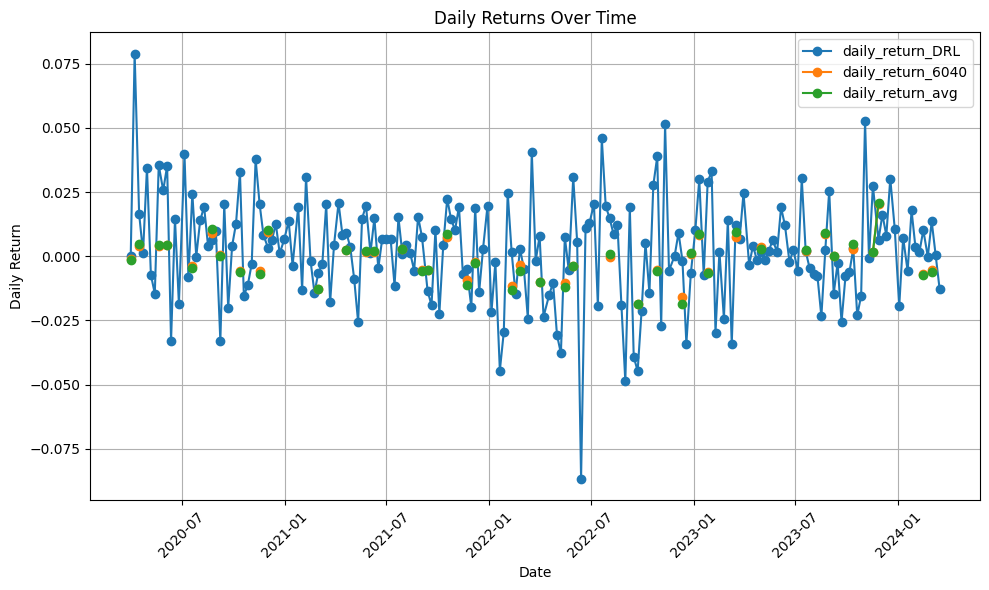

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt

# 資料
dates = daily_return_result['date']
daily_return_DRL = daily_return_result['daily_return_DRL']
daily_return_6040 = daily_return_result['daily_return_6040']
daily_return_avg = daily_return_result['daily_return_avg']

# 繪製折線圖
plt.figure(figsize=(10, 6))
plt.plot(dates, daily_return_DRL, marker='o', label='daily_return_DRL')
plt.plot(dates, daily_return_6040, marker='o', label='daily_return_6040')
plt.plot(dates, daily_return_avg, marker='o', label='daily_return_avg')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# 顯示圖表
plt.show()

In [126]:
cumulative_drl = (1 + daily_return_result['daily_return_DRL']).cumprod() - 1
cumulative_6040 = (1 + daily_return_result['daily_return_6040']).cumprod() - 1
cumulative_avg = (1 + daily_return_result['daily_return_avg']).cumprod() - 1

In [127]:
cumulative_returns_result = pd.DataFrame({'date':daily_return_result['date'], 'cumulative_drl': cumulative_drl, 'cumulative_6040': cumulative_6040, 'cumulative_avg': cumulative_avg })


In [109]:
# baseline_returns.fillna(0,inplace=True)
baseline_returns[baseline_returns.index.isin(date.to_list())]

Series([], Name: daily_return, dtype: float64)

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (400, 8)


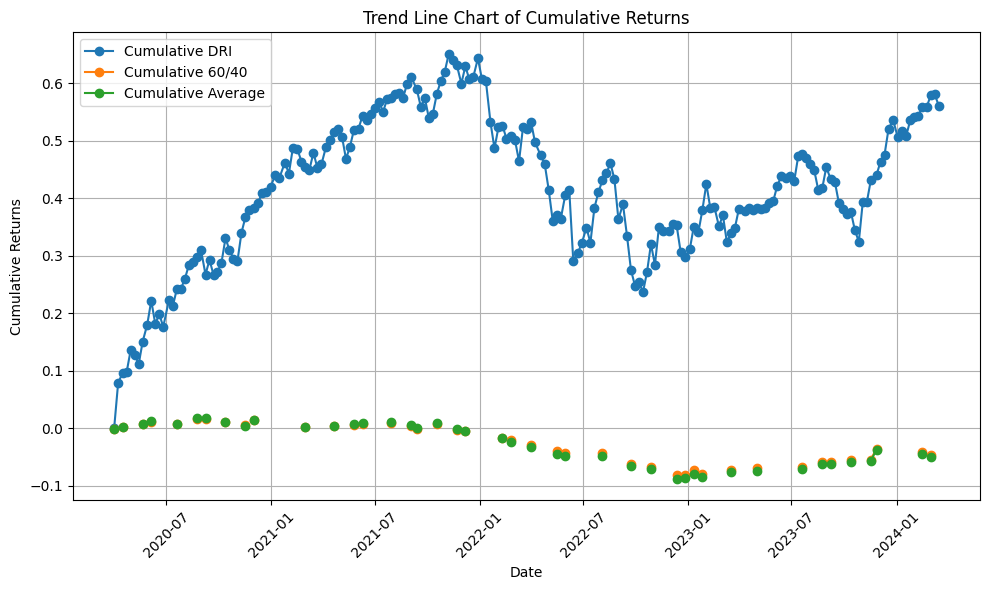

In [128]:
baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")


date = cumulative_returns_result['date']
cumulative_drl = cumulative_returns_result['cumulative_drl']
cumulative_6040 = cumulative_returns_result['cumulative_6040']
cumulative_avg =cumulative_returns_result['cumulative_avg']

# 繪製趨勢值線圖
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_drl, marker='o', label='Cumulative DRI')
plt.plot(dates, cumulative_6040, marker='o', label='Cumulative 60/40')
plt.plot(dates, cumulative_avg, marker='o', label='Cumulative Average')
# plt.plot(dates, baseline_returns, marker='o', label='Cumulative DJI')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Trend Line Chart of Cumulative Returns')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# 顯示圖表
plt.show()

In [100]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return.loc[0,'date'], end='2021-11-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (400, 8)


KeyError: "[Timestamp('2020-04-02 00:00:00+0000', tz='UTC'), Timestamp('2020-04-03 00:00:00+0000', tz='UTC'), Timestamp('2020-04-06 00:00:00+0000', tz='UTC'), Timestamp('2020-04-07 00:00:00+0000', tz='UTC'), Timestamp('2020-04-09 00:00:00+0000', tz='UTC'), Timestamp('2020-04-13 00:00:00+0000', tz='UTC'), Timestamp('2020-04-14 00:00:00+0000', tz='UTC'), Timestamp('2020-04-15 00:00:00+0000', tz='UTC'), Timestamp('2020-04-17 00:00:00+0000', tz='UTC'), Timestamp('2020-04-20 00:00:00+0000', tz='UTC'), Timestamp('2020-04-21 00:00:00+0000', tz='UTC'), Timestamp('2020-04-22 00:00:00+0000', tz='UTC'), Timestamp('2020-04-24 00:00:00+0000', tz='UTC'), Timestamp('2020-04-27 00:00:00+0000', tz='UTC'), Timestamp('2020-04-28 00:00:00+0000', tz='UTC'), Timestamp('2020-04-29 00:00:00+0000', tz='UTC'), Timestamp('2020-05-01 00:00:00+0000', tz='UTC'), Timestamp('2020-05-04 00:00:00+0000', tz='UTC'), Timestamp('2020-05-05 00:00:00+0000', tz='UTC'), Timestamp('2020-05-06 00:00:00+0000', tz='UTC'), Timestamp('2020-05-08 00:00:00+0000', tz='UTC'), Timestamp('2020-05-11 00:00:00+0000', tz='UTC'), Timestamp('2020-05-12 00:00:00+0000', tz='UTC'), Timestamp('2020-05-13 00:00:00+0000', tz='UTC'), Timestamp('2020-05-15 00:00:00+0000', tz='UTC'), Timestamp('2020-05-18 00:00:00+0000', tz='UTC'), Timestamp('2020-05-19 00:00:00+0000', tz='UTC'), Timestamp('2020-05-20 00:00:00+0000', tz='UTC'), Timestamp('2020-05-22 00:00:00+0000', tz='UTC'), Timestamp('2020-05-26 00:00:00+0000', tz='UTC'), Timestamp('2020-05-27 00:00:00+0000', tz='UTC'), Timestamp('2020-05-28 00:00:00+0000', tz='UTC'), Timestamp('2020-06-01 00:00:00+0000', tz='UTC'), Timestamp('2020-06-02 00:00:00+0000', tz='UTC'), Timestamp('2020-06-03 00:00:00+0000', tz='UTC'), Timestamp('2020-06-04 00:00:00+0000', tz='UTC'), Timestamp('2020-06-08 00:00:00+0000', tz='UTC'), Timestamp('2020-06-09 00:00:00+0000', tz='UTC'), Timestamp('2020-06-10 00:00:00+0000', tz='UTC'), Timestamp('2020-06-11 00:00:00+0000', tz='UTC'), Timestamp('2020-06-15 00:00:00+0000', tz='UTC'), Timestamp('2020-06-16 00:00:00+0000', tz='UTC'), Timestamp('2020-06-17 00:00:00+0000', tz='UTC'), Timestamp('2020-06-18 00:00:00+0000', tz='UTC'), Timestamp('2020-06-22 00:00:00+0000', tz='UTC'), Timestamp('2020-06-23 00:00:00+0000', tz='UTC'), Timestamp('2020-06-24 00:00:00+0000', tz='UTC'), Timestamp('2020-06-25 00:00:00+0000', tz='UTC'), Timestamp('2020-06-29 00:00:00+0000', tz='UTC'), Timestamp('2020-06-30 00:00:00+0000', tz='UTC'), Timestamp('2020-07-01 00:00:00+0000', tz='UTC'), Timestamp('2020-07-02 00:00:00+0000', tz='UTC'), Timestamp('2020-07-07 00:00:00+0000', tz='UTC'), Timestamp('2020-07-08 00:00:00+0000', tz='UTC'), Timestamp('2020-07-09 00:00:00+0000', tz='UTC'), Timestamp('2020-07-10 00:00:00+0000', tz='UTC'), Timestamp('2020-07-14 00:00:00+0000', tz='UTC'), Timestamp('2020-07-15 00:00:00+0000', tz='UTC'), Timestamp('2020-07-16 00:00:00+0000', tz='UTC'), Timestamp('2020-07-17 00:00:00+0000', tz='UTC'), Timestamp('2020-07-21 00:00:00+0000', tz='UTC'), Timestamp('2020-07-22 00:00:00+0000', tz='UTC'), Timestamp('2020-07-23 00:00:00+0000', tz='UTC'), Timestamp('2020-07-24 00:00:00+0000', tz='UTC'), Timestamp('2020-07-28 00:00:00+0000', tz='UTC'), Timestamp('2020-07-29 00:00:00+0000', tz='UTC'), Timestamp('2020-07-30 00:00:00+0000', tz='UTC'), Timestamp('2020-07-31 00:00:00+0000', tz='UTC'), Timestamp('2020-08-04 00:00:00+0000', tz='UTC'), Timestamp('2020-08-05 00:00:00+0000', tz='UTC'), Timestamp('2020-08-06 00:00:00+0000', tz='UTC'), Timestamp('2020-08-07 00:00:00+0000', tz='UTC'), Timestamp('2020-08-11 00:00:00+0000', tz='UTC'), Timestamp('2020-08-12 00:00:00+0000', tz='UTC'), Timestamp('2020-08-13 00:00:00+0000', tz='UTC'), Timestamp('2020-08-14 00:00:00+0000', tz='UTC'), Timestamp('2020-08-18 00:00:00+0000', tz='UTC'), Timestamp('2020-08-19 00:00:00+0000', tz='UTC'), Timestamp('2020-08-20 00:00:00+0000', tz='UTC'), Timestamp('2020-08-21 00:00:00+0000', tz='UTC'), Timestamp('2020-08-25 00:00:00+0000', tz='UTC'), Timestamp('2020-08-26 00:00:00+0000', tz='UTC'), Timestamp('2020-08-27 00:00:00+0000', tz='UTC'), Timestamp('2020-08-28 00:00:00+0000', tz='UTC'), Timestamp('2020-09-01 00:00:00+0000', tz='UTC'), Timestamp('2020-09-02 00:00:00+0000', tz='UTC'), Timestamp('2020-09-03 00:00:00+0000', tz='UTC'), Timestamp('2020-09-04 00:00:00+0000', tz='UTC'), Timestamp('2020-09-09 00:00:00+0000', tz='UTC'), Timestamp('2020-09-10 00:00:00+0000', tz='UTC'), Timestamp('2020-09-11 00:00:00+0000', tz='UTC'), Timestamp('2020-09-14 00:00:00+0000', tz='UTC'), Timestamp('2020-09-16 00:00:00+0000', tz='UTC'), Timestamp('2020-09-17 00:00:00+0000', tz='UTC'), Timestamp('2020-09-18 00:00:00+0000', tz='UTC'), Timestamp('2020-09-21 00:00:00+0000', tz='UTC'), Timestamp('2020-09-23 00:00:00+0000', tz='UTC'), Timestamp('2020-09-24 00:00:00+0000', tz='UTC'), Timestamp('2020-09-25 00:00:00+0000', tz='UTC'), Timestamp('2020-09-28 00:00:00+0000', tz='UTC'), Timestamp('2020-09-30 00:00:00+0000', tz='UTC'), Timestamp('2020-10-01 00:00:00+0000', tz='UTC'), Timestamp('2020-10-02 00:00:00+0000', tz='UTC'), Timestamp('2020-10-05 00:00:00+0000', tz='UTC'), Timestamp('2020-10-07 00:00:00+0000', tz='UTC'), Timestamp('2020-10-08 00:00:00+0000', tz='UTC'), Timestamp('2020-10-09 00:00:00+0000', tz='UTC'), Timestamp('2020-10-12 00:00:00+0000', tz='UTC'), Timestamp('2020-10-14 00:00:00+0000', tz='UTC'), Timestamp('2020-10-15 00:00:00+0000', tz='UTC'), Timestamp('2020-10-16 00:00:00+0000', tz='UTC'), Timestamp('2020-10-19 00:00:00+0000', tz='UTC'), Timestamp('2020-10-21 00:00:00+0000', tz='UTC'), Timestamp('2020-10-22 00:00:00+0000', tz='UTC'), Timestamp('2020-10-23 00:00:00+0000', tz='UTC'), Timestamp('2020-10-26 00:00:00+0000', tz='UTC'), Timestamp('2020-10-28 00:00:00+0000', tz='UTC'), Timestamp('2020-10-29 00:00:00+0000', tz='UTC'), Timestamp('2020-10-30 00:00:00+0000', tz='UTC'), Timestamp('2020-11-02 00:00:00+0000', tz='UTC'), Timestamp('2020-11-04 00:00:00+0000', tz='UTC'), Timestamp('2020-11-05 00:00:00+0000', tz='UTC'), Timestamp('2020-11-06 00:00:00+0000', tz='UTC'), Timestamp('2020-11-09 00:00:00+0000', tz='UTC'), Timestamp('2020-11-11 00:00:00+0000', tz='UTC'), Timestamp('2020-11-12 00:00:00+0000', tz='UTC'), Timestamp('2020-11-13 00:00:00+0000', tz='UTC'), Timestamp('2020-11-16 00:00:00+0000', tz='UTC'), Timestamp('2020-11-18 00:00:00+0000', tz='UTC'), Timestamp('2020-11-19 00:00:00+0000', tz='UTC'), Timestamp('2020-11-20 00:00:00+0000', tz='UTC'), Timestamp('2020-11-23 00:00:00+0000', tz='UTC'), Timestamp('2020-11-25 00:00:00+0000', tz='UTC'), Timestamp('2020-11-27 00:00:00+0000', tz='UTC'), Timestamp('2020-11-30 00:00:00+0000', tz='UTC'), Timestamp('2020-12-01 00:00:00+0000', tz='UTC'), Timestamp('2020-12-03 00:00:00+0000', tz='UTC'), Timestamp('2020-12-04 00:00:00+0000', tz='UTC'), Timestamp('2020-12-07 00:00:00+0000', tz='UTC'), Timestamp('2020-12-08 00:00:00+0000', tz='UTC'), Timestamp('2020-12-10 00:00:00+0000', tz='UTC'), Timestamp('2020-12-11 00:00:00+0000', tz='UTC'), Timestamp('2020-12-14 00:00:00+0000', tz='UTC'), Timestamp('2020-12-15 00:00:00+0000', tz='UTC'), Timestamp('2020-12-17 00:00:00+0000', tz='UTC'), Timestamp('2020-12-18 00:00:00+0000', tz='UTC'), Timestamp('2020-12-21 00:00:00+0000', tz='UTC'), Timestamp('2020-12-22 00:00:00+0000', tz='UTC'), Timestamp('2020-12-24 00:00:00+0000', tz='UTC'), Timestamp('2020-12-28 00:00:00+0000', tz='UTC'), Timestamp('2020-12-29 00:00:00+0000', tz='UTC'), Timestamp('2020-12-30 00:00:00+0000', tz='UTC'), Timestamp('2021-01-04 00:00:00+0000', tz='UTC'), Timestamp('2021-01-05 00:00:00+0000', tz='UTC'), Timestamp('2021-01-06 00:00:00+0000', tz='UTC'), Timestamp('2021-01-07 00:00:00+0000', tz='UTC'), Timestamp('2021-01-11 00:00:00+0000', tz='UTC'), Timestamp('2021-01-12 00:00:00+0000', tz='UTC'), Timestamp('2021-01-13 00:00:00+0000', tz='UTC'), Timestamp('2021-01-14 00:00:00+0000', tz='UTC'), Timestamp('2021-01-19 00:00:00+0000', tz='UTC'), Timestamp('2021-01-20 00:00:00+0000', tz='UTC'), Timestamp('2021-01-21 00:00:00+0000', tz='UTC'), Timestamp('2021-01-22 00:00:00+0000', tz='UTC'), Timestamp('2021-01-26 00:00:00+0000', tz='UTC'), Timestamp('2021-01-27 00:00:00+0000', tz='UTC'), Timestamp('2021-01-28 00:00:00+0000', tz='UTC'), Timestamp('2021-01-29 00:00:00+0000', tz='UTC'), Timestamp('2021-02-02 00:00:00+0000', tz='UTC'), Timestamp('2021-02-03 00:00:00+0000', tz='UTC'), Timestamp('2021-02-04 00:00:00+0000', tz='UTC'), Timestamp('2021-02-05 00:00:00+0000', tz='UTC'), Timestamp('2021-02-09 00:00:00+0000', tz='UTC'), Timestamp('2021-02-10 00:00:00+0000', tz='UTC'), Timestamp('2021-02-11 00:00:00+0000', tz='UTC'), Timestamp('2021-02-12 00:00:00+0000', tz='UTC'), Timestamp('2021-02-17 00:00:00+0000', tz='UTC'), Timestamp('2021-02-18 00:00:00+0000', tz='UTC'), Timestamp('2021-02-19 00:00:00+0000', tz='UTC'), Timestamp('2021-02-22 00:00:00+0000', tz='UTC'), Timestamp('2021-02-24 00:00:00+0000', tz='UTC'), Timestamp('2021-02-25 00:00:00+0000', tz='UTC'), Timestamp('2021-02-26 00:00:00+0000', tz='UTC'), Timestamp('2021-03-01 00:00:00+0000', tz='UTC'), Timestamp('2021-03-03 00:00:00+0000', tz='UTC'), Timestamp('2021-03-04 00:00:00+0000', tz='UTC'), Timestamp('2021-03-05 00:00:00+0000', tz='UTC'), Timestamp('2021-03-08 00:00:00+0000', tz='UTC'), Timestamp('2021-03-10 00:00:00+0000', tz='UTC'), Timestamp('2021-03-11 00:00:00+0000', tz='UTC'), Timestamp('2021-03-12 00:00:00+0000', tz='UTC'), Timestamp('2021-03-15 00:00:00+0000', tz='UTC'), Timestamp('2021-03-17 00:00:00+0000', tz='UTC'), Timestamp('2021-03-18 00:00:00+0000', tz='UTC'), Timestamp('2021-03-19 00:00:00+0000', tz='UTC'), Timestamp('2021-03-22 00:00:00+0000', tz='UTC'), Timestamp('2021-03-24 00:00:00+0000', tz='UTC'), Timestamp('2021-03-25 00:00:00+0000', tz='UTC'), Timestamp('2021-03-26 00:00:00+0000', tz='UTC'), Timestamp('2021-03-29 00:00:00+0000', tz='UTC'), Timestamp('2021-03-31 00:00:00+0000', tz='UTC'), Timestamp('2021-04-01 00:00:00+0000', tz='UTC'), Timestamp('2021-04-05 00:00:00+0000', tz='UTC'), Timestamp('2021-04-06 00:00:00+0000', tz='UTC'), Timestamp('2021-04-08 00:00:00+0000', tz='UTC'), Timestamp('2021-04-09 00:00:00+0000', tz='UTC'), Timestamp('2021-04-12 00:00:00+0000', tz='UTC'), Timestamp('2021-04-13 00:00:00+0000', tz='UTC'), Timestamp('2021-04-15 00:00:00+0000', tz='UTC'), Timestamp('2021-04-16 00:00:00+0000', tz='UTC'), Timestamp('2021-04-19 00:00:00+0000', tz='UTC'), Timestamp('2021-04-20 00:00:00+0000', tz='UTC'), Timestamp('2021-04-22 00:00:00+0000', tz='UTC'), Timestamp('2021-04-23 00:00:00+0000', tz='UTC'), Timestamp('2021-04-26 00:00:00+0000', tz='UTC'), Timestamp('2021-04-27 00:00:00+0000', tz='UTC'), Timestamp('2021-04-29 00:00:00+0000', tz='UTC'), Timestamp('2021-04-30 00:00:00+0000', tz='UTC'), Timestamp('2021-05-03 00:00:00+0000', tz='UTC'), Timestamp('2021-05-04 00:00:00+0000', tz='UTC'), Timestamp('2021-05-06 00:00:00+0000', tz='UTC'), Timestamp('2021-05-07 00:00:00+0000', tz='UTC'), Timestamp('2021-05-10 00:00:00+0000', tz='UTC'), Timestamp('2021-05-11 00:00:00+0000', tz='UTC'), Timestamp('2021-05-13 00:00:00+0000', tz='UTC'), Timestamp('2021-05-14 00:00:00+0000', tz='UTC'), Timestamp('2021-05-17 00:00:00+0000', tz='UTC'), Timestamp('2021-05-18 00:00:00+0000', tz='UTC'), Timestamp('2021-05-20 00:00:00+0000', tz='UTC'), Timestamp('2021-05-21 00:00:00+0000', tz='UTC'), Timestamp('2021-05-24 00:00:00+0000', tz='UTC'), Timestamp('2021-05-25 00:00:00+0000', tz='UTC'), Timestamp('2021-05-27 00:00:00+0000', tz='UTC'), Timestamp('2021-05-28 00:00:00+0000', tz='UTC'), Timestamp('2021-06-01 00:00:00+0000', tz='UTC'), Timestamp('2021-06-02 00:00:00+0000', tz='UTC'), Timestamp('2021-06-04 00:00:00+0000', tz='UTC'), Timestamp('2021-06-07 00:00:00+0000', tz='UTC'), Timestamp('2021-06-08 00:00:00+0000', tz='UTC'), Timestamp('2021-06-09 00:00:00+0000', tz='UTC'), Timestamp('2021-06-11 00:00:00+0000', tz='UTC'), Timestamp('2021-06-14 00:00:00+0000', tz='UTC'), Timestamp('2021-06-15 00:00:00+0000', tz='UTC'), Timestamp('2021-06-16 00:00:00+0000', tz='UTC'), Timestamp('2021-06-18 00:00:00+0000', tz='UTC'), Timestamp('2021-06-21 00:00:00+0000', tz='UTC'), Timestamp('2021-06-22 00:00:00+0000', tz='UTC'), Timestamp('2021-06-23 00:00:00+0000', tz='UTC'), Timestamp('2021-06-25 00:00:00+0000', tz='UTC'), Timestamp('2021-06-28 00:00:00+0000', tz='UTC'), Timestamp('2021-06-29 00:00:00+0000', tz='UTC'), Timestamp('2021-06-30 00:00:00+0000', tz='UTC'), Timestamp('2021-07-02 00:00:00+0000', tz='UTC'), Timestamp('2021-07-06 00:00:00+0000', tz='UTC'), Timestamp('2021-07-07 00:00:00+0000', tz='UTC'), Timestamp('2021-07-08 00:00:00+0000', tz='UTC'), Timestamp('2021-07-12 00:00:00+0000', tz='UTC'), Timestamp('2021-07-13 00:00:00+0000', tz='UTC'), Timestamp('2021-07-14 00:00:00+0000', tz='UTC'), Timestamp('2021-07-15 00:00:00+0000', tz='UTC'), Timestamp('2021-07-19 00:00:00+0000', tz='UTC'), Timestamp('2021-07-20 00:00:00+0000', tz='UTC'), Timestamp('2021-07-21 00:00:00+0000', tz='UTC'), Timestamp('2021-07-22 00:00:00+0000', tz='UTC'), Timestamp('2021-07-26 00:00:00+0000', tz='UTC'), Timestamp('2021-07-27 00:00:00+0000', tz='UTC'), Timestamp('2021-07-28 00:00:00+0000', tz='UTC'), Timestamp('2021-07-29 00:00:00+0000', tz='UTC'), Timestamp('2021-08-02 00:00:00+0000', tz='UTC'), Timestamp('2021-08-03 00:00:00+0000', tz='UTC'), Timestamp('2021-08-04 00:00:00+0000', tz='UTC'), Timestamp('2021-08-05 00:00:00+0000', tz='UTC'), Timestamp('2021-08-09 00:00:00+0000', tz='UTC'), Timestamp('2021-08-10 00:00:00+0000', tz='UTC'), Timestamp('2021-08-11 00:00:00+0000', tz='UTC'), Timestamp('2021-08-12 00:00:00+0000', tz='UTC'), Timestamp('2021-08-16 00:00:00+0000', tz='UTC'), Timestamp('2021-08-17 00:00:00+0000', tz='UTC'), Timestamp('2021-08-18 00:00:00+0000', tz='UTC'), Timestamp('2021-08-19 00:00:00+0000', tz='UTC'), Timestamp('2021-08-23 00:00:00+0000', tz='UTC'), Timestamp('2021-08-24 00:00:00+0000', tz='UTC'), Timestamp('2021-08-25 00:00:00+0000', tz='UTC'), Timestamp('2021-08-26 00:00:00+0000', tz='UTC'), Timestamp('2021-08-30 00:00:00+0000', tz='UTC'), Timestamp('2021-08-31 00:00:00+0000', tz='UTC'), Timestamp('2021-09-01 00:00:00+0000', tz='UTC'), Timestamp('2021-09-02 00:00:00+0000', tz='UTC'), Timestamp('2021-09-07 00:00:00+0000', tz='UTC'), Timestamp('2021-09-08 00:00:00+0000', tz='UTC'), Timestamp('2021-09-09 00:00:00+0000', tz='UTC'), Timestamp('2021-09-10 00:00:00+0000', tz='UTC'), Timestamp('2021-09-14 00:00:00+0000', tz='UTC'), Timestamp('2021-09-15 00:00:00+0000', tz='UTC'), Timestamp('2021-09-16 00:00:00+0000', tz='UTC'), Timestamp('2021-09-17 00:00:00+0000', tz='UTC'), Timestamp('2021-09-21 00:00:00+0000', tz='UTC'), Timestamp('2021-09-22 00:00:00+0000', tz='UTC'), Timestamp('2021-09-23 00:00:00+0000', tz='UTC'), Timestamp('2021-09-24 00:00:00+0000', tz='UTC'), Timestamp('2021-09-28 00:00:00+0000', tz='UTC'), Timestamp('2021-09-29 00:00:00+0000', tz='UTC'), Timestamp('2021-09-30 00:00:00+0000', tz='UTC'), Timestamp('2021-10-01 00:00:00+0000', tz='UTC'), Timestamp('2021-10-05 00:00:00+0000', tz='UTC'), Timestamp('2021-10-06 00:00:00+0000', tz='UTC'), Timestamp('2021-10-07 00:00:00+0000', tz='UTC'), Timestamp('2021-10-08 00:00:00+0000', tz='UTC'), Timestamp('2021-10-12 00:00:00+0000', tz='UTC'), Timestamp('2021-10-13 00:00:00+0000', tz='UTC'), Timestamp('2021-10-14 00:00:00+0000', tz='UTC'), Timestamp('2021-10-15 00:00:00+0000', tz='UTC'), Timestamp('2021-10-19 00:00:00+0000', tz='UTC'), Timestamp('2021-10-20 00:00:00+0000', tz='UTC'), Timestamp('2021-10-21 00:00:00+0000', tz='UTC'), Timestamp('2021-10-22 00:00:00+0000', tz='UTC'), Timestamp('2021-10-26 00:00:00+0000', tz='UTC'), Timestamp('2021-10-27 00:00:00+0000', tz='UTC'), Timestamp('2021-10-28 00:00:00+0000', tz='UTC'), Timestamp('2021-10-29 00:00:00+0000', tz='UTC')] not in index"

In [508]:
# 計算DRL 的資產配置，其殖利率
start_date = '2020-04-01'
end_date = '2024-03-31'
stock_list = ["SPY","AGG","QQQ","VNQ","IWM","VIG","IEF"]
close_price = data_df[['date','tic','close']]
date_ranage = close_price.query(f'tic == "AGG" & date >= "2020-04-01"')[['date']] #empty
result = date_ranage.reset_index(drop=True)

for i in stock_list:
    sticker = yf.Ticker(i)

    dividends  = sticker.dividends
    dividends = dividends .reset_index()
    dividends['Date'] = dividends['Date'].dt.tz_localize(None)
    dividends = dividends.query('Date >= "2020-04-01"')


    tmp_close = close_price.query(f'tic == "{i}"')[['date','close']]
    tmp_result = dividends.merge(tmp_close , how='left', left_on='Date', right_on='date')
    tmp_result.drop('Date', axis=1, inplace=True)
    tmp_result.dropna(inplace=True)
    tmp_result[f'{i}_dividends_rate'] = tmp_result['Dividends']/tmp_result['close']*100 # 計算殖利率
    tmp_result = tmp_result[['date',f'{i}_dividends_rate']]

    result = result.merge(tmp_result, on='date', how ='left')

result = result.fillna(0)
condition  = result.query('SPY_dividends_rate <=0 & \
              AGG_dividends_rate <=0 & \
             QQQ_dividends_rate <=0 & \
             VNQ_dividends_rate <=0 & \
             VIG_dividends_rate <=0 & \
             IEF_dividends_rate <=0').index
result.drop(condition, inplace=True) # result 資產組合各自的殖利率


#資產組合比例
df_actions_reset = actions_memory[0].reset_index()
result = df_actions_reset.merge(result, on='date', how='outer').fillna(method = 'ffill')
        

In [535]:
df_actions_reset.to_csv('./dividends_result_action.csv',index=False)

In [525]:
# final_dividends_result = {result['date']}
total_dividends = result[f'{stock_list[0]}'] * result[f'{stock_list[0]}_dividends_rate'] + \
    result[f'{stock_list[1]}'] * result[f'{stock_list[1]}_dividends_rate'] + \
    result[f'{stock_list[2]}'] * result[f'{stock_list[2]}_dividends_rate'] + \
    result[f'{stock_list[3]}'] * result[f'{stock_list[3]}_dividends_rate'] + \
    result[f'{stock_list[4]}'] * result[f'{stock_list[4]}_dividends_rate'] + \
    result[f'{stock_list[5]}'] * result[f'{stock_list[5]}_dividends_rate'] + \
    result[f'{stock_list[6]}'] * result[f'{stock_list[6]}_dividends_rate'] 

result['total_dividends'] = total_dividends
print('Avg_dividends',result['total_dividends'].describe()['mean'])
    

Avg_dividends 0.06903028725660394


In [532]:
for i in stock_list:
    sticker = yf.Ticker(i)

    dividends  = sticker.dividends
    dividends = dividends .reset_index()
    dividends['Date'] = dividends['Date'].dt.tz_localize(None)
    dividends = dividends.query('Date >= "2020-04-01"')


    tmp_close = close_price.query(f'tic == "{i}"')[['date','close']]
    tmp_result = dividends.merge(tmp_close , how='left', left_on='Date', right_on='date')
    tmp_result.drop('Date', axis=1, inplace=True)
    tmp_result.dropna(inplace=True)
    tmp_result[f'{i}_dividends_rate'] = tmp_result['Dividends']/tmp_result['close']*100 # 計算殖利率
    tmp_result = tmp_result[['date',f'{i}_dividends_rate']]

In [521]:
0.031004397567 + 0.016885268829 

0.047889666395999994

In [389]:
# 定義資產持有比例和殖利率
持有比例 = [0.095817, 0.260458, 0.095817, 0.260458, 0.095817, 0.095817, 0.095817]
殖利率 = [0.15, 0.22, 0.25, 0.26, 0.55, 0.89, 0]

# 計算加權平均殖利率
投資組合殖利率 = sum([a*b for a, b in zip(持有比例, 殖利率)])

print(f"投資組合的殖利率為: {投資組合殖利率:.4f}")

投資組合的殖利率為: 0.3013
